# COMPLEX SOUNDING VIEWER
#### AN ADVANCED & MODERN SOUNDING DATA PLOTTER. 

(C) 2023 Kyle J Gillett | @wxkylegillett 

------------

### Thanks for checking out this notebook! 
### This notebook inputs SounderPy observed profile data and plots it on a sounding 
- You can implement this sounding viewer with whatever profile data you have!
- To use this, simply download it to your machine, ensure you have the required dependencies, & run it
- This notebook is likely to be updated in the future to increase it's complexity. 

#### Enjoy!

In [1]:
# IMPORT SOFTWARE ---------------------------------------------------
# BUILT IN
from datetime import datetime, timedelta
import time
import csv
import sys
import requests
from urllib.request import urlopen
import warnings
# OTHER
import cdsapi
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
from scipy import interpolate
from ecape.calc import calc_ecape, _get_parcel_profile, calc_mse, calc_integral_arg, calc_lfc_height, calc_el_height
# MATPLOTLIB
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# METPY
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT, Hodograph
# SIPHON 
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from siphon.simplewebservice.wyoming import WyomingUpperAir
from siphon.simplewebservice.iastate import IAStateUpperAir
from siphon.simplewebservice.igra2 import IGRAUpperAir
# SOUNDERPY 
from sounderpy import get_obs_data


## ------------------ VERTICAL PROFILE DATA RETRIEVAL TOOL ------------------------ ##
##                           v2.0.4 | August 6th, 2023                              ##
##                             (C) KYLE J GILLETT                                   ##
##  THIS TOOL LOADS RAOB, IGRA, RAP, RUC, ERA5, RAP-ANALYSIS, & BUFKIT PROFILE DATA ##
## -------------------- THANK YOU FOR USING THIS PACKAGE -------------------------- ##



In [2]:
# USER DATA------------------------------
your_name = 'YOUR NAME'     # add your name here to add it to the plot!
year      = '2014'          # launch year                          
month     = '06'            # launch month
day       = '16'            # launch day
hour      = '18'            # launch hour 
station   = 'OAX'           # 3 digit station id

# CALL UP SOUNDERPY
clean_data = get_obs_data(station, year, month, day, hour)

# SET UP DATA 
p  = clean_data['p']
z  = clean_data['z']
T  = clean_data['T']
Td = clean_data['Td']
u  = clean_data['u']
v  = clean_data['v']


-- OBSERVED DATA ACCESS FUNCTION --
-----------------------------------
FOUND RAOB: OAX on 06/16/2014 at 18z | From UW
RUNTIME: 00:00:01


------------------------------------------------------
The sounding is now loading. This may take a second...
 
 


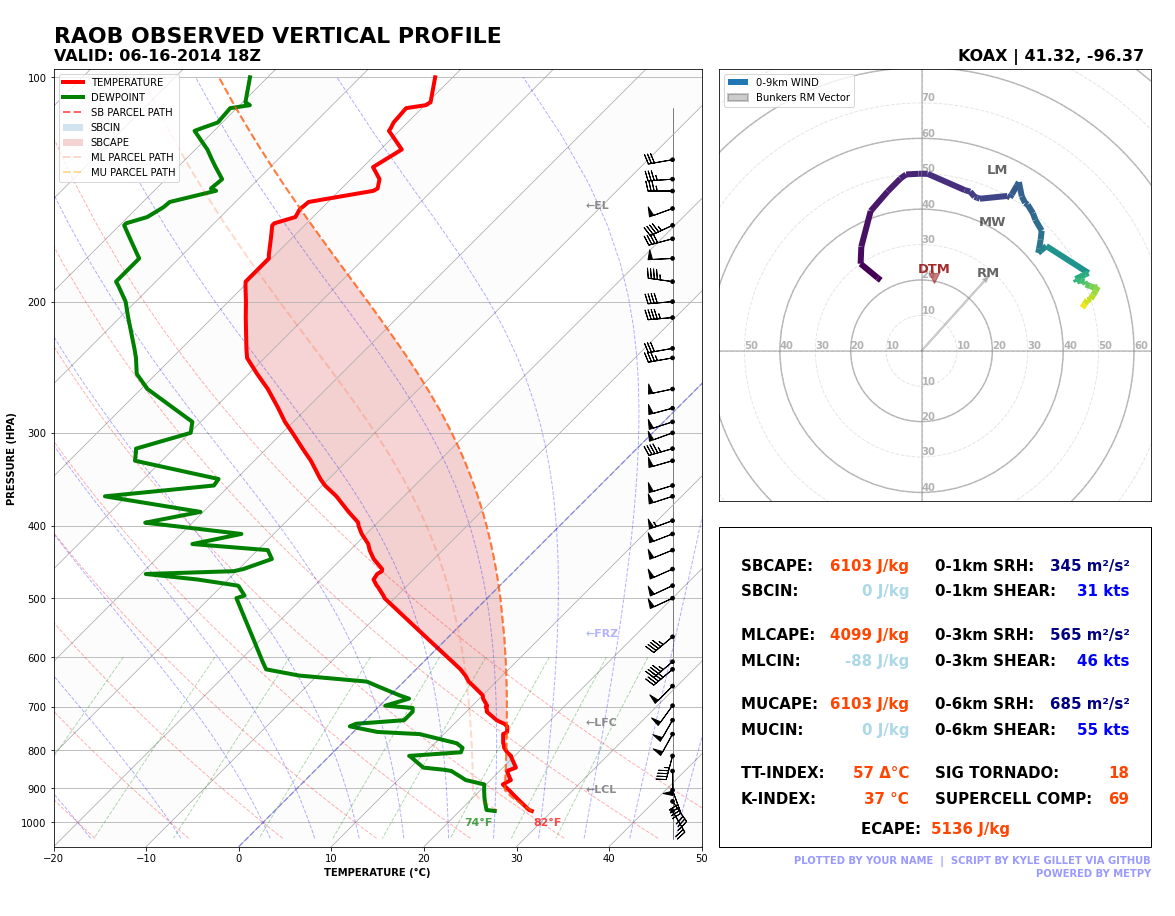

 
 
RUNTIME: 00:00:02


In [3]:
st = time.time()   
    
# ADD A SIMPLE PLOT TITLE---------------------------------------------------
left_title = f"VALID: {clean_data['site_info']['valid-time'][1]}-{clean_data['site_info']['valid-time'][2]}-{clean_data['site_info']['valid-time'][0]} {clean_data['site_info']['valid-time'][3]}Z"
right_title = f"{clean_data['site_info']['site-id']} | {clean_data['site_info']['site-latlon'][0]}, {clean_data['site_info']['site-latlon'][1]}" 
top_title = 'RAOB OBSERVED VERTICAL PROFILE'

# DEFINE find_nearest FUNCTION ----------------------------------------------- 
def find_nearest(array, value):
    array = np.asarray(array)
    nearest_idx = (np.abs(array - value)).argmin()
    return nearest_idx

# CREATE THE METPY SKEWT FIGURE ----------------------------------------------- 
fig = plt.figure(figsize=(18,12))                             
skew = SkewT(fig, rotation=45, rect=(0, 0, 0.50, 0.90)) 
# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-20, 50)
# Set some better labels than the default to increase readability
skew.ax.set_xlabel(str.upper(f'Temperature ({T.units:~P})'), weight='bold')
skew.ax.set_ylabel(str.upper(f'Pressure ({p.units:~P})'), weight='bold')
# Set the facecolor of the Skew Object and the Figure to white
fig.set_facecolor('#ffffff')         
skew.ax.set_facecolor('#ffffff')     
# Here we can use some basic math and python functionality to make a cool
# shaded isotherm pattern. 
x1 = np.linspace(-100, 40, 8)                                                          
x2 = np.linspace(-90, 50, 8)                                                         
y = [1200, 50]                                                                      
for i in range(0, 8):              
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)   
    
# TEMPERATURE & DEWPOINT TRACE --------------------------------------------------
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
# set the linewidth to 4 for increased readability. 
# We will also add the 'label' kew word argument for our legend. 
skew.plot(p, T, 'r', lw=4, label='TEMPERATURE')
skew.plot(p, Td, 'g', lw=4, label='DEWPOINT')


# WIND BARBS --------------------------------------------------------------------
# again we can use some simple python math functionality to 'resample'
# the wind barbs for a cleaner output with increased readability. 
# Something like this would work.
interval = np.logspace(2.113, 3, 40) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval) 
# create blank barbs for small dot at the start of each actual barb
blank_len = len(u[idx])         
blank = np.zeros(blank_len)
skew.plot_barbs(pressure=p[idx],u=blank,v=blank,xloc=0.955,fill_empty=True,
                sizes=dict(emptybarb=0.075, width=0.18, height=0.4))
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx],xloc=0.955,fill_empty=True,
                sizes=dict(emptybarb=0.075, width=0.18, height=0.4), length=7)
# Draw line underneath wind barbs
line = mpl.lines.Line2D([0.955, 0.955], [0.01,0.95],color='black',linewidth=0.5,
                     transform=skew.ax.transAxes,clip_on=False,zorder=1)
skew.ax.add_line(line) 


# OTHER RELEVANT LINES -----------------------------------------------------------
# Add the relevant special lines native to the Skew-T Log-P diagram &
# provide basic adjustments to linewidth and alpha to increase readability
# first we add a matplotlib axvline to highlight the 0 degree isotherm
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)


# PARCEL PROPERTIES --------------------------------------------------------------
# Calculate full parcel profile and add to plot as black line
# mixed layer parcel properties!
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=100 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=100 * units.hPa)
# most unstable parcel properties!
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=100 * units.hPa)
# Compute parcel profiles
sb_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
mu_prof = mpcalc.parcel_profile(p, mu_t, mu_td).to('degC')
ml_prof = mpcalc.parcel_profile(p, ml_t, ml_td).to('degC')
# compute CAPE & CIN
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, ml_prof, depth=100 * units.hPa)
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)

try: 
    q = mpcalc.specific_humidity_from_dewpoint(p, Td)
    ecape = int(calc_ecape(z, p, T, q, u, v, 'most_unstable').m)
    mse_star, mse_bar = calc_mse(p, z, T, q)
    int_arg = calc_integral_arg(mse_bar, mse_star, T)
    ecape_lfc = calc_lfc_height(p, z, T, Td, parcel_func = mpcalc.mixed_parcel)
    ecape_el = calc_el_height(p, z, T, Td, parcel_func = mpcalc.mixed_parcel)
except:
    ecape = -9999*units.joule/units.kilogram
    pass

lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td, which='most_cape')
el_pressure, el_temperature = mpcalc.el(p, T, Td, which='most_cape')

# make minor corrections to CAPE amount to match SHARPPY (SPC) output
sbcape = (sbcape.m + (sbcape.m*(0.10)))*units('J/kg')
mucape = (mucape.m + (mucape.m*(0.10)))*units('J/kg')
mlcape = (mlcape.m + (mlcape.m*(0.10)))*units('J/kg')


# PLOT PARCEL-RELATED 'LEVELS' & SHADE CAPE/CIN ---------------------------------
# always plot LCL
plt.text((0.82), (lcl_pressure), "←LCL", weight='bold',color='gray',             
         alpha=0.9, fontsize=11, transform=skew.ax.get_yaxis_transform())

# only plot LFC, EL, SB trace, & CAPE shade when SBCAPE is > 10
if sbcape.m > 10:
    plt.text((0.82), (lfc_pressure), "←LFC", weight='bold',color='gray',          
             alpha=0.9, fontsize=11, transform=skew.ax.get_yaxis_transform())
    plt.text((0.82), (el_pressure), "←EL", weight='bold',color='gray',             
             alpha=0.9, fontsize=11, transform=skew.ax.get_yaxis_transform())
    skew.plot(p, sb_prof, 'red', linewidth=2, ls='--', alpha=0.6, label='SB PARCEL PATH')
    # Shade areas of CAPE and CIN
    skew.shade_cin(p, T, sb_prof, Td, alpha=0.2, label='SBCIN')
    skew.shade_cape(p, T, sb_prof, alpha=0.2, label='SBCAPE')
    
# plot ML-trace when MLCAPE > 10
if mlcape.m > 10:
    skew.plot(p, ml_prof, 'orangered', linewidth=2, ls='--', alpha=0.2, label='ML PARCEL PATH')            
    # Shade areas of CAPE and CIN
    # skew.shade_cin(p, T, ml_prof, Td, alpha=0.2, label='MLCIN')
    # skew.shade_cape(p, T, ml_prof, alpha=0.2, label='MLCAPE') 

# plot MU-trace when MUCAPE > 10
if mucape.m > 10:
    skew.plot(p, mu_prof, 'orange', linewidth=2, ls='--', alpha=0.4, label='MU PARCEL PATH')
    # Shade areas of CAPE and CIN
    #skew.shade_cin(p, T, mu_prof, Td, alpha=0.2, label='MUCIN')
    #skew.shade_cape(p, T, mu_prof, alpha=0.2, label='MUCAPE')
    
    
# SURFACE TEMPERATURE & DEWPOINT ANNOTATIONS ------------------------------------
T_degF = np.round(T.to(units.degF), 1)
T_degF_label = '{}°F'.format(int(T_degF[0].magnitude))                             
plt.annotate(T_degF_label, (T[0], p[0]), textcoords="offset points", xytext=(16,-15),
                 fontsize=11, color='red', weight='bold', alpha=0.7, ha='center')   
Td_degF = np.round(Td.to(units.degF), 1) 
Td_degF_label = '{}°F'.format(int(Td_degF[0].magnitude))                             
plt.annotate(Td_degF_label,(Td[0], p[0]),textcoords="offset points",xytext=(-16,-15), 
                 fontsize=11, color='green', weight='bold', alpha=0.7, ha='center') 


# FREEZING POINT ANNOTATION -----------------------------------------------------
T_list = T.m.tolist()          
res = list(filter(lambda i: i <= 0, T_list))[0]
frz_pt_index = T_list.index(res) 
frz_pt_p = p[frz_pt_index]     
frz_pt_z = z[frz_pt_index]  
if frz_pt_z >= 50*units.m:                                                       
    plt.text((0.82), (frz_pt_p), "←FRZ", weight='bold',color='blue',           
             alpha=0.3, fontsize=11, transform=skew.ax.get_yaxis_transform())
    
    
# CREATE METPY HODOGRAPH --------------------------------------------------------
# Create a hodograph object: first we need to add an axis
# determine max height of wind data to plot on hodograph in km (if hodo_layer = 9, 0-9km u and v are plotted)
hodo_layer = int(9)

# remove nan values from base wind u and v component arrays to find min & max values.
u_clean = u.magnitude[np.logical_not(np.isnan(u.magnitude))]
v_clean = v.magnitude[np.logical_not(np.isnan(v.magnitude))]

# restructure u and v, p, ws and z data arrays based on corrected u and v arrays and hodo_layer depth
p_hodo, u_hodo, v_hodo = mpcalc.get_layer(p, u, v, depth=hodo_layer*units.km)

# define x and y min/max values from 'cleaned' and restructured u and v arrays
x_min = u_hodo.min().m
y_min = v_hodo.min().m
x_max = u_hodo.max().m
y_max = v_hodo.max().m

# if statements to determine approprate x axis and y axis limits (to change dynamically with the data)
if y_max >= 0:
    y_Maxlimit = (y_max + 15)
if y_max < 0:
    y_Maxlimit = (y_max + 15)
if x_max >= 0:
    x_Maxlimit = (x_max + 15)
if x_max < 0:
    x_Maxlimit = (x_max + 15)
if y_min >= 0:
    y_Minlimit = (y_min - 40)
if y_min < 0:
    y_Minlimit = (y_min - 40)
if x_min >= 0:
    x_Minlimit = (x_min - 40)
if x_min < 0:
    x_Minlimit = (x_min - 40)
    
# then we can create the metpy Hodograph
hodo_ax = plt.axes((0.43, 0.40, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)

# Add two seperate grid increments for a cooler look. This also
# helps to increase readability
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)

# The next few steps makes for a clean hodograph inset, removing the 
# tick marks, tick labels and axis labels
h.ax.set_box_aspect(1) 
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')
h.ax.set_xlim(x_Minlimit, x_Maxlimit)
h.ax.set_ylim(y_Minlimit, y_Maxlimit)  

# Here we can add a simple python for loop that adds tick marks to the inside 
# of the hodograph plot to increase readability! 
plt.xticks(np.arange(0,0,1))
plt.yticks(np.arange(0,0,1))
for i in range(10,120,10):
    h.ax.annotate(str(i),(i,0),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=10,weight='bold',alpha=0.3,zorder=0)
for i in range(10,120,10):
    h.ax.annotate(str(i),(0,i),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=10,weight='bold',alpha=0.3,zorder=0)
for i in range(10,120,10):
    h.ax.annotate(str(i),(-i,0),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=10,weight='bold',alpha=0.3,zorder=0)
for i in range(10,120,10):
    h.ax.annotate(str(i),(0,-i),xytext=(0,2),textcoords='offset pixels',clip_on=True,fontsize=10,weight='bold',alpha=0.3,zorder=0)
    
# plot the hodograph itself, using plot_colormapped, colored
# by height 
idx_9km = find_nearest(z, z[0].m+9000)
h.plot_colormapped(u[0:idx_9km], v[0:idx_9km], c=z[0:idx_9km], linewidth=6, label="0-9km WIND")

# compute Bunkers storm motion so we can plot it on the hodograph! 
RM, LM, MW = mpcalc.bunkers_storm_motion(p[0:idx_9km], u[0:idx_9km], v[0:idx_9km], z[0:idx_9km])
h.ax.text((RM[0].m), (RM[1].m), 'RM', weight='bold', ha='center', fontsize=13, alpha=0.6) 
h.ax.text((LM[0].m), (LM[1].m), 'LM', weight='bold', ha='center', fontsize=13, alpha=0.6) 
h.ax.text((MW[0].m), (MW[1].m), 'MW', weight='bold', ha='center', fontsize=13, alpha=0.6) 
h.ax.arrow(0,0,RM[0].m, RM[1].m, linewidth=2, color='black', alpha=0.2, label='Bunkers RM Vector', 
           length_includes_head=True, head_width=1)

#SHARPPY MEAN WIND FROM 0-300m
idx_300m = find_nearest(z, z[0].m+300)
MW_300m_u = sum(u[0:idx_300m].m)/len(u[0:idx_300m].m)
MW_300m_v = sum(v[0:idx_300m].m)/len(v[0:idx_300m].m)

#DTM CALC
DTM_u = (RM[0].m+MW_300m_u)/2
DTM_v = (RM[1].m+MW_300m_v)/2
h.ax.text((DTM_u), (DTM_v + 1.4), 'DTM', weight='bold', fontsize=13, color='brown', ha='center')
h.plot(DTM_u, DTM_v, marker='v', color='brown', markersize=10, alpha=0.6)


# First we want to actually add values of data to the plot for easy viewing
# to do this, lets first add a simple rectangle using matplotlib's 'patches' 
# fucntionality to add some simple layout for plotting calculated parameters 
#                                  xloc   yloc   xsize  ysize
fig.patches.extend([plt.Rectangle((0.513, 0.00), 0.334, 0.37,
                                  edgecolor='black', facecolor='white', linewidth=1, alpha=1,
                                  transform=fig.transFigure, figure=fig)])


# COMPUTE METPY PARAMETERS -----------------------------------------------------------
# now lets take a moment to calculate some simple severe-weather parameters using
# metpy's calculations 
# here are some classic severe parameters!
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
# Compute SRH 
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km,
                                                    storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km,
                                                    storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km,
                                                    storm_u=u_storm, storm_v=v_storm)

# Copmute Bulk Shear components and then magnitude
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

# Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

# Use all computed pieces to calculate the Significant Tornado parameter
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                     total_helicity3, bshear3).to_base_units()

# Perform the calculation of supercell composite if an effective layer exists
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)


# PRINT VALUES OF PARAMETERS TO THE PLOT ------------------------------------------------
# there is a lot we can do with this data operationally, so lets plot some of
# these values right on the plot, in the box we made
# first lets plot some thermodynamic parameters
plt.figtext( 0.53, 0.32,  f'SBCAPE: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.66, 0.32,  f'{int(sbcape.m)} J/kg', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext( 0.53, 0.29,  f'SBCIN: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.66, 0.29,  f'{int(sbcin.m)} J/kg', weight='bold', fontsize=15, color='lightblue', ha='right')
plt.figtext( 0.53, 0.24,  f'MLCAPE: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.66, 0.24,  f'{int(mlcape.m)} J/kg', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext( 0.53, 0.21,  f'MLCIN: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.66, 0.21,  f'{int(mlcin.m)} J/kg', weight='bold', fontsize=15, color='lightblue', ha='right')
plt.figtext( 0.53, 0.16,  f'MUCAPE: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.66, 0.16,  f'{int(mucape.m)} J/kg', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext( 0.53, 0.13,  f'MUCIN: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.66, 0.13,  f'{int(mucin.m)} J/kg', weight='bold', fontsize=15, color='lightblue', ha='right')
plt.figtext( 0.53, 0.08,  f'TT-INDEX: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.66, 0.08,  f'{int(total_totals.m)} Δ°C', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext( 0.53, 0.05,  f'K-INDEX: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.66, 0.05,  f'{int(kindex.m)} °C', weight='bold', fontsize=15, color='orangered', ha='right')
# now some kinematic parameters
met_per_sec = (units.m*units.m)/(units.sec*units.sec)
plt.figtext( 0.68, 0.32,  f'0-1km SRH: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.83, 0.32,  f'{int(total_helicity1.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext( 0.68, 0.29,  f'0-1km SHEAR: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.83, 0.29,  f'{int(bshear1.m)} kts', weight='bold', fontsize=15, color='blue', ha='right')
plt.figtext( 0.68, 0.24,  f'0-3km SRH: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.83, 0.24,  f'{int(total_helicity3.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext( 0.68, 0.21,  f'0-3km SHEAR: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.83, 0.21,  f'{int(bshear3.m)} kts', weight='bold', fontsize=15, color='blue', ha='right')
plt.figtext( 0.68, 0.16,  f'0-6km SRH: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.83, 0.16,  f'{int(total_helicity6.m)* met_per_sec:~P}', weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext( 0.68, 0.13,  f'0-6km SHEAR: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.83, 0.13,  f'{int(bshear6.m)} kts', weight='bold', fontsize=15, color='blue', ha='right')
plt.figtext( 0.68, 0.08,  f'SIG TORNADO: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.83, 0.08,  f'{int(sig_tor.m)}', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext( 0.68, 0.05,  f'SUPERCELL COMP: ', weight='bold', fontsize=15, color='black', ha='left')
plt.figtext( 0.83, 0.05,  f'{int(super_comp.m)}', weight='bold', fontsize=15, color='orangered', ha='right')
plt.figtext( 0.673, 0.015,  f'ECAPE: ', weight='bold', fontsize=15, color='black', ha='right')
plt.figtext( 0.677, 0.015,  f'{int(ecape)} J/kg', weight='bold', fontsize=15, color='orangered', ha='left')


# LEGEND --------------------------------------------------------------------------------------
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')


# PLOT TITLES ----------------------------------------------------------------------------------
plt.figtext( 0.000, 0.91, left_title, ha='left', weight='bold', fontsize=16)
plt.figtext( 0.85, 0.91, f'{right_title}  ', ha='right', weight='bold', fontsize=16)
plt.figtext( 0.000, 0.93, top_title, ha='left', weight='bold', fontsize=22) 
plt.figtext( 0.86, -0.02,  f'PLOTTED BY {str.upper(your_name)}  |  SCRIPT BY KYLE GILLET VIA GITHUB     ', ha='right', color='blue', alpha=0.4, weight='bold', fontsize=10)
plt.figtext( 0.86, -0.035,  f'POWERED BY METPY     ', ha='right', color='blue', alpha=0.4, weight='bold', fontsize=10)

print('------------------------------------------------------')
print('The sounding is now loading. This may take a second...')
print(' \n ')

# Show the plot
plt.show()

print(' \n ')
elapsed_time = time.time() - st
print('RUNTIME:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))